# [EDA] Explotatory Data Analysis

In [1]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt

dataset = os.path.join('dataset_processed.csv')
df = pd.read_csv(dataset)

# convert to Timestamp and index
df['timestamp'] = df.apply(lambda x: datetime.strptime(x.timestamp, '%Y-%m-%d %H:%M:%S'), axis=1)
df.set_index('timestamp', inplace=True)

# extract assets and variables
assets = list(set([x[-4:] for x in df.columns]))
print ("Number of different assets = {}".format(len(assets)))
variables = list(set([x[:-5] for x in df.columns]))
print ("Number of different variables = {}".format(len(variables)))

# types, extracted from listing the variables
var_type = ['Phi', 'Temp', 'Speed', 'Press', 'Direction', 'Angle', 'Power']

Number of different assets = 5
Number of different variables = 28


# 0) Missing data analysis
The original file contains gaps, the gaps have been analyzed here below using pandas after application of moving average

In [2]:
import numpy as np

df_null = pd.DataFrame(columns=assets, index=variables)
for a in assets:
    cols = [v+'_'+a for v in variables]
    df_null.loc[:,a] = df[cols].isnull().sum().values
df_null

A004  A002  A005  A001  A003
WROTPitchAngleSP        19     3    87    13    23
WGENGenSpeed            19     3    87    13    23
WROTPitchAngleAvg       19     3    87    13    23
WCNVNetVoltage          19     3    87    13    23
WCNVCosPhi              19     3    87    13    23
WGENPhase3Temp          19     3    87    13    23
WGENBearNDETemp         19     3    87    13    23
WNACWindDirection       19     3    87    13    23
WHDRGroupOilPress       19     3    87    13    23
WYAWPressure            19     3    87    13    23
WTRMBearTemp            19     3    87    13    23
WTURReactivePower       19     3    87    13    23
WGDCTrafoPhase3Temp     19     3    87    13    23
WNACAmbTemp             19     3    87    13    23
WHDRGroupOilTemp        19     3    87    13    23
WGDCTrafoPhase2Temp     19     3    87    13    23
WTURPower               19     3    87    13    23
WROTSpeed               19     3    87    13    23
WNACWindSpeed           19     3    87    13    23
WTURPowerAux            19     3    87    13    23
WNACNacelleTemp         19     3    87    13    23
WGENPhase2Temp          19     3    87    13    23
WGENPhase1Temp          19     3    87    13    23
WGENBearDETemp          19     3    87    13    23
WTRMOilTemp             19     3    87    13    23
WTURReactivePowerAux    19     3    87    13    23
WNACDirection           19     3    87    13    23
WGDCTrafoPhase1Temp     19     3    87    13    23

This computation shows that all the gaps are shared by the variables of the same asset. In other words, one can see that we have gaps per asset affecting all the variables. 
Let's produce a report of all the gaps to see how many are there.

In [3]:
# add a report of the gaps found
nan_df = pd.DataFrame(columns=['start', 'stop', 'duration', 'asset'])
col_to_inspect = [variables[0]+'_'+a for a in assets]
for a in assets:
    c = variables[0]+'_'+a
    nan_times = df.loc[df[c].isnull()].index
    jumps = [np.where(nan_times==x)[0][0] for x,y in zip(nan_times[:-1], np.diff(nan_times)) if y > np.timedelta64(10, 'm')]
    starts = [0]
    starts.extend(np.array(jumps)+1)
    starts.extend([len(nan_times)])
    for i in range(len(starts[:-1])):        
        t_start = nan_times[starts[i]]
        t_stop = nan_times[starts[i+1]-1] + np.timedelta64(10, 'm')        
        nan_df = nan_df.append({'start':str(t_start), 'stop':t_stop, 'duration':str(t_stop-t_start), "asset":a}, ignore_index=True)
nan_df.sort_values(by='start')

start                stop         duration asset
3  2015-05-06 06:20:00 2015-05-06 13:30:00  0 days 07:10:00  A005
4  2015-05-07 06:20:00 2015-05-07 13:20:00  0 days 07:00:00  A005
0  2015-05-18 09:40:00 2015-05-18 12:20:00  0 days 02:40:00  A004
2  2015-05-21 11:10:00 2015-05-21 11:40:00  0 days 00:30:00  A002
1  2015-05-21 11:40:00 2015-05-21 12:10:00  0 days 00:30:00  A004
7  2015-05-25 09:50:00 2015-05-25 13:20:00  0 days 03:30:00  A003
5  2015-05-25 11:40:00 2015-05-25 12:00:00  0 days 00:20:00  A005
6  2015-05-26 09:00:00 2015-05-26 11:10:00  0 days 02:10:00  A001
8  2015-05-27 11:10:00 2015-05-27 11:30:00  0 days 00:20:00  A003

# 1) Time Analysis

For a given asset, all the variables are analyzed to see what is their shape and what are the correlations among them.
The goal of this analysis is twofold:

* 1) To inspect if there are outliers on the data.
* 2) To inspect the general shape of the data and their histogram for posterior analysis.

## 1.1) Outlier analysis
The following section shows how many points fall outside of the interval $3 \sigma$ for each variable.
A value is considered anomaly if surpasses that threshold:

$$ o_x(n)=1 \leftarrow (x(n)>\mu_x + 3\sigma_x) \cup (x(n)<\mu_x - 3 \sigma_x)$$

The matrix below shows how many outliers are there for each variable, and each asset

In [4]:
outlier_mask_df = (df>df.mean()+3*df.std()) | (df<df.mean()-3*df.std())
foo = pd.DataFrame(outlier_mask_df.sum(axis=0))
foo['asset'] = [x[-4:] for x in foo.index]
foo['variable'] = [x[:-5] for x in foo.index]
foo = pd.pivot_table(foo, columns='asset', index='variable')
foo

0                    
asset                A001 A002 A003 A004 A005
variable                                     
WCNVCosPhi             15  124  140  125  105
WCNVNetVoltage         13   11    8   11   42
WGDCTrafoPhase1Temp     2    0    3    0   47
WGDCTrafoPhase2Temp     2    0    6    0   15
WGDCTrafoPhase3Temp     6    0    6    0   30
WGENBearDETemp          0   18    2    2   35
WGENBearNDETemp        35   87   25   89   89
WGENGenSpeed          143  115  135   99  170
WGENPhase1Temp         50    6   37   16   55
WGENPhase2Temp         48   11   27    7   62
WGENPhase3Temp         44    5   31    4   56
WHDRGroupOilPress       0    0    0    0    1
WHDRGroupOilTemp       21   14    6    6   13
WNACAmbTemp             0    0    0    0    0
WNACDirection           0    0    0    0    0
WNACNacelleTemp         0    0    0    0    0
WNACWindDirection      90   86   86   80   93
WNACWindSpeed          33   32   35   32   37
WROTPitchAngleAvg     145  119  136  102  174
WROTPitchAngleSP      144  119  136  102  174
WROTSpeed             143  115  135   99  171
WTRMBearTemp           69   54   77   51   95
WTRMOilTemp            33   44   24   32   68
WTURPower               0    0    0    0    0
WTURPowerAux           12   19   40   50   29
WTURReactivePower     164  189  154  177   36
WTURReactivePowerAux   19   41   33   46   23
WYAWPressure          229  219  219  235  217

## 1.2) Time and distributions for each variable
This section plots the signal and the histogram for every variable, and all of the five assets.

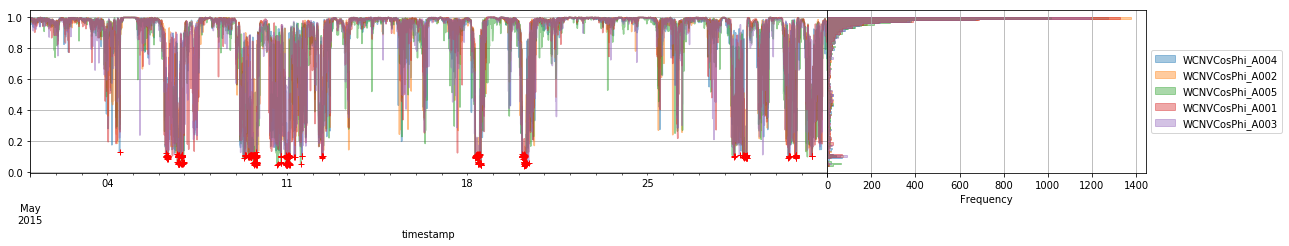

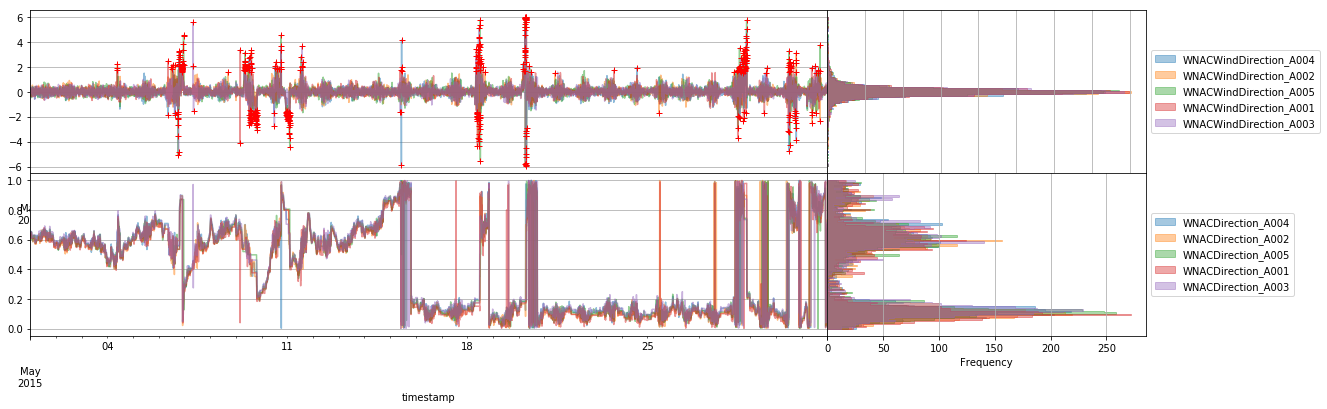

In [5]:
def plot_vars(var_list):
    f, ax = plt.subplots(len(var_list), 2, figsize=(20,len(var_list)*3), gridspec_kw={'width_ratios':[5,2]}) 
    for v in var_list:
        tmp_vars = [v + '_' + x for x in assets]
        pos = var_list.index(v)
        tmp_ax = ax[:] if len(var_list) == 1 else ax[pos,:]       
        df[tmp_vars].plot(ax=tmp_ax[0], legend=False, alpha=0.5)    
        (df[tmp_vars]*outlier_mask_df[tmp_vars].replace(False, np.nan)).plot(ax=tmp_ax[0], style='r+', legend=False)
        tmp_ax[0].grid()
        df[tmp_vars].plot(kind='hist', ax=tmp_ax[1], bins=100, orientation='horizontal', histtype='step', fill=True, alpha=0.4)
        tmp_ax[1].grid()
        tmp_ax[1].get_yaxis().set_visible(False)
        tmp_ax[1].legend(loc='center left', bbox_to_anchor=(1., 0.5))
        f.subplots_adjust(wspace=0)
        f.subplots_adjust(hspace=0)
    plt.show()
# plot per type of variable
for vt in var_type:
    tmp_vars = [v for v in variables if vt in v]    
    plot_vars(tmp_vars)

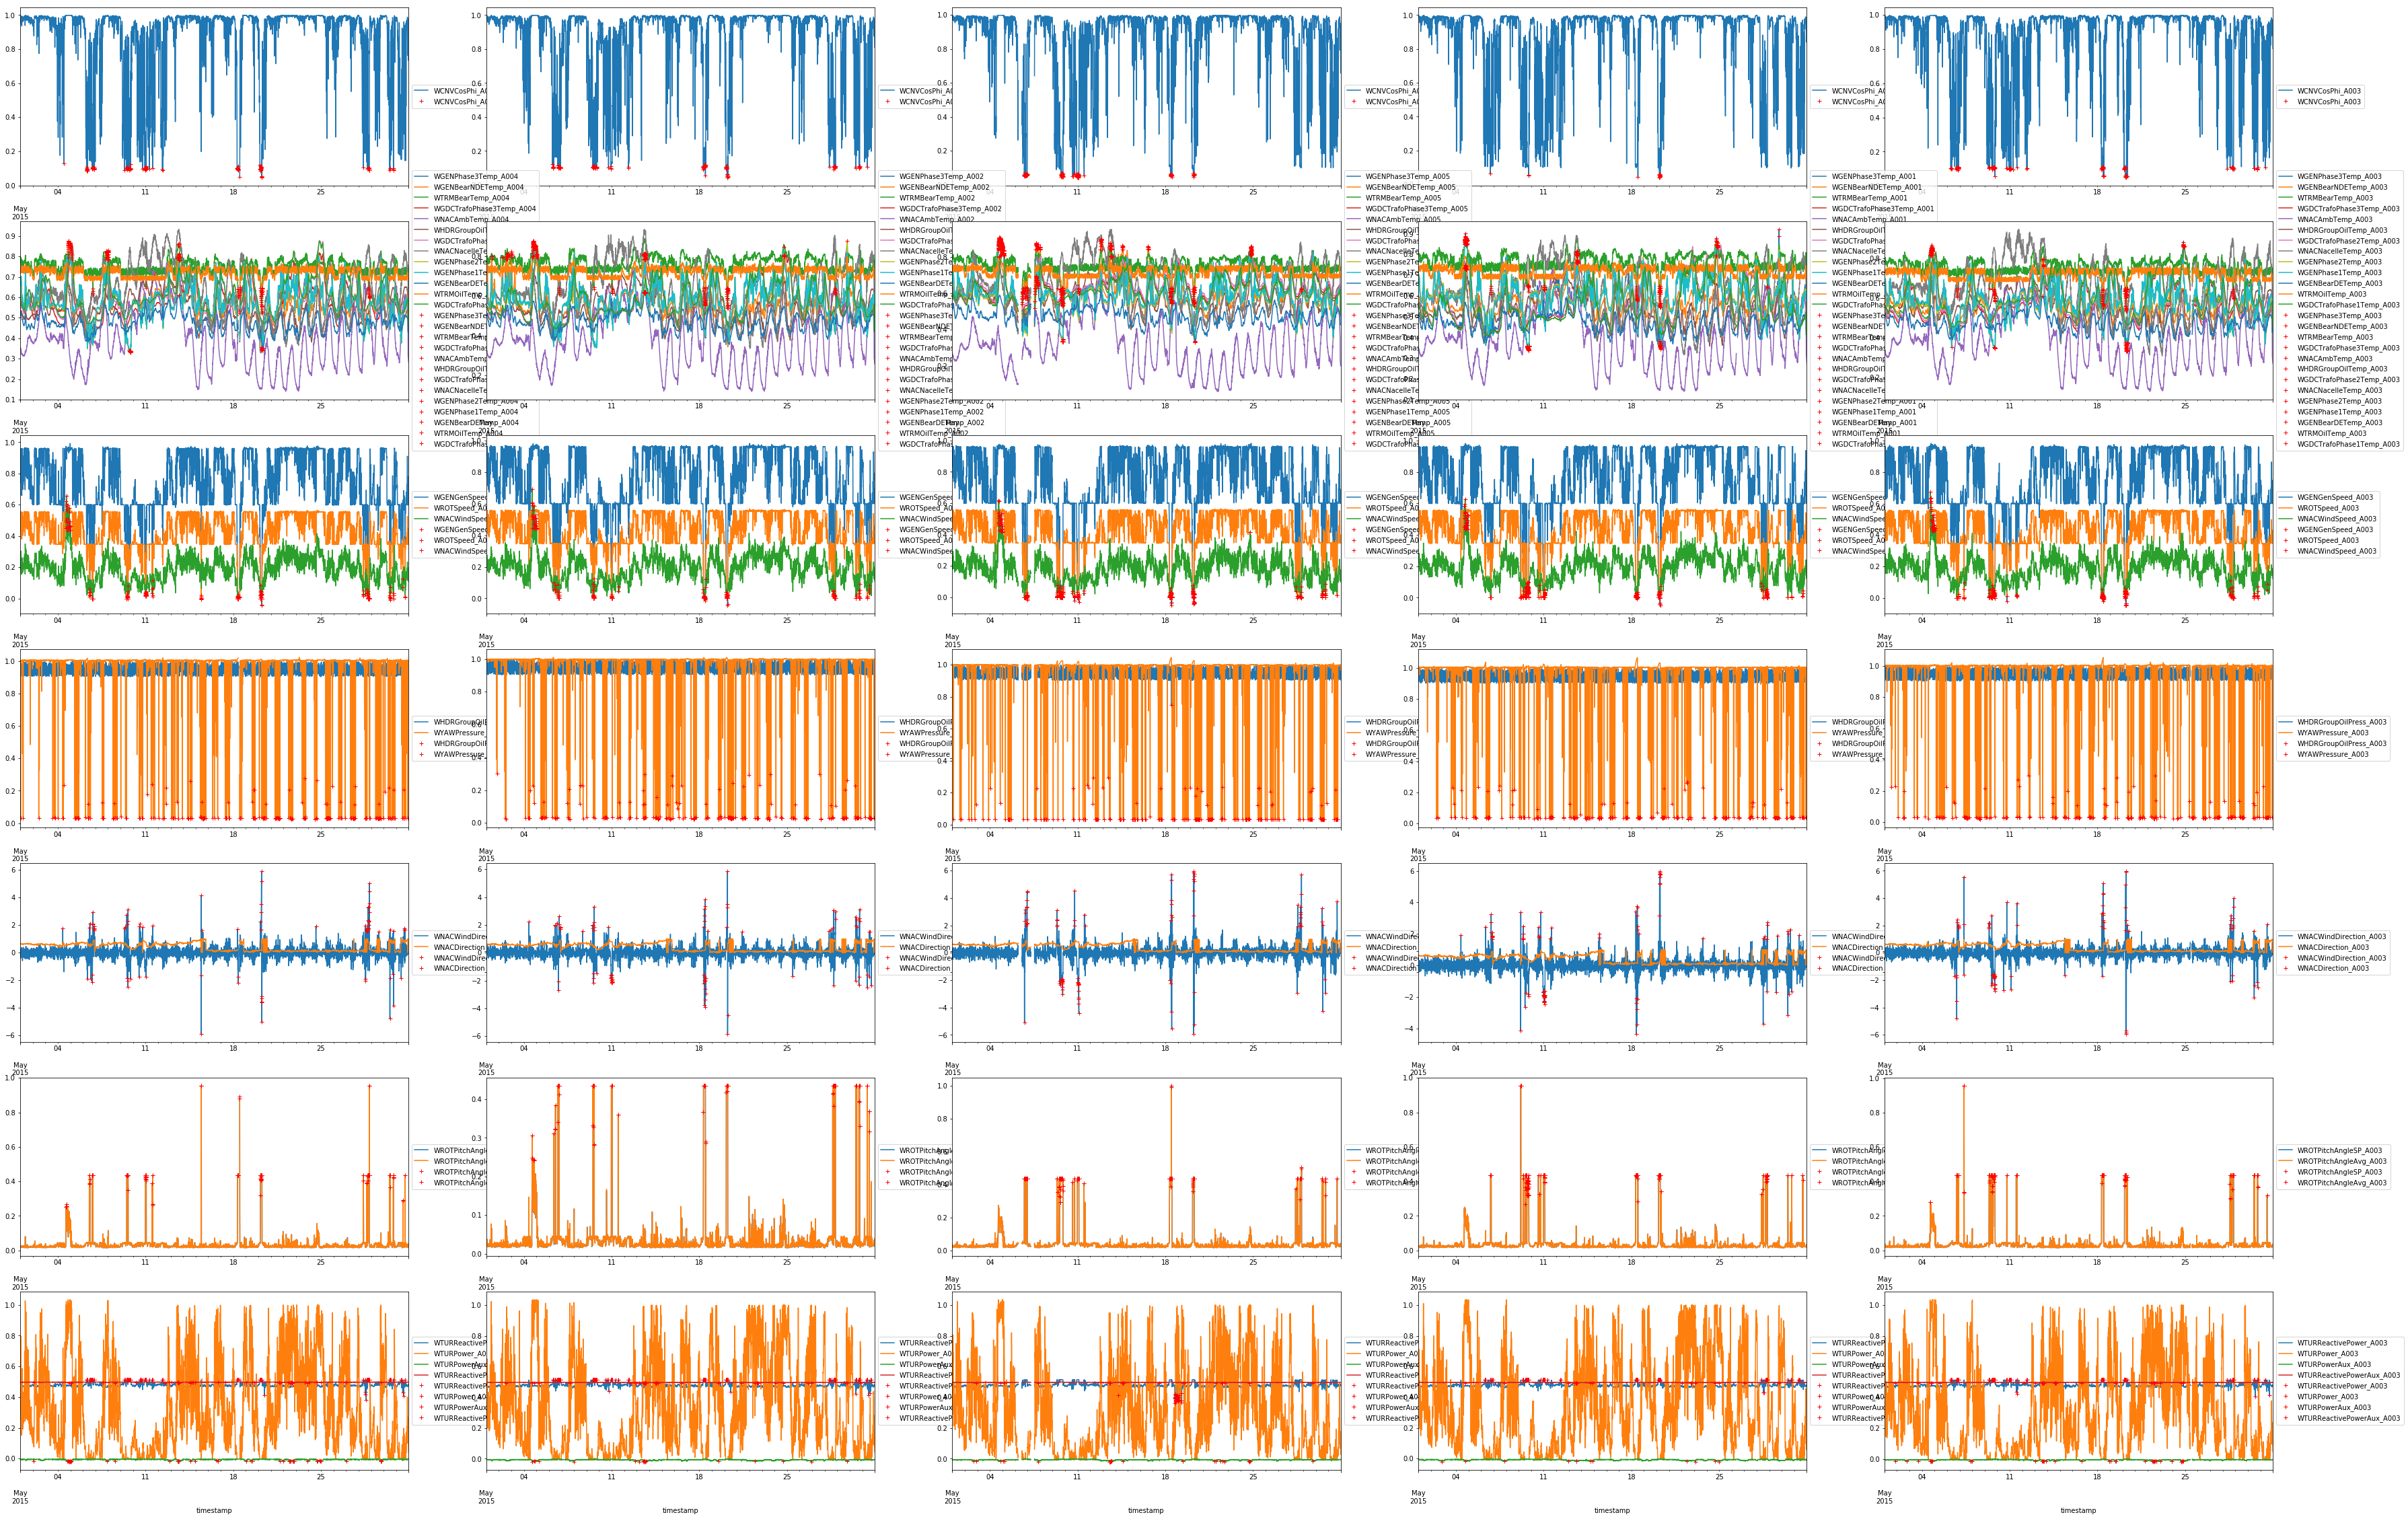

In [6]:
# types, extracted from listing the variables
var_type = ['Phi', 'Temp', 'Speed', 'Press', 'Direction', 'Angle', 'Power']
f, ax = plt.subplots(len(var_type), len(assets), figsize=(60,40))
for v in var_type: 
    for a in assets:        
        tmp_vars = [x + '_' + a for x in variables if v in x]
        pos_y = assets.index(a)
        pos_x = var_type.index(v)
        df[tmp_vars].plot(ax=ax[pos_x, pos_y])
        (df[tmp_vars]*outlier_mask_df[tmp_vars].replace(False, np.nan)).plot(ax=ax[pos_x,pos_y], style='r+', legend=False)
        ax[pos_x,pos_y].legend(loc='center left', bbox_to_anchor=(1., 0.5))
plt.show()

# 1.2) Correlation

From the previous plots it is clear that there is a big correlation between the same variables of different assets. There is no need to analyze such correlation as it will be obviously big.

However, one may be interested in seeing the correlation between variables of the same asset, or the mean of the assets. The idea is to surface correlations among variables, not among assets.

If we analyze the correlations for all the 140 variables-asset tuples, we will see that the high values of the correlations are clustered in groups of 5 elements.

*NOTE 1*: a scatter matrix would give us the same information at this scale for so many variables, a correlation matrix is preferred.

*NOTE 2*: we are interested in absolute correlation (there is or there is not), so the values are scaled.

In [7]:
plt.figure(figsize=(12,12))
corr_matrix = abs(df.corr())
plt.imshow(corr_matrix, cmap='jet')
plt.xticks(range(corr_matrix.shape[0]),df.columns, rotation='vertical')
plt.yticks(range(corr_matrix.shape[1]),df.columns)
plt.colorbar()
plt.title("Absolute correlation for all assets")
plt.show()

Now, if we analyze only the correlations for one of the assets, we will see how much information is contained in one variable.

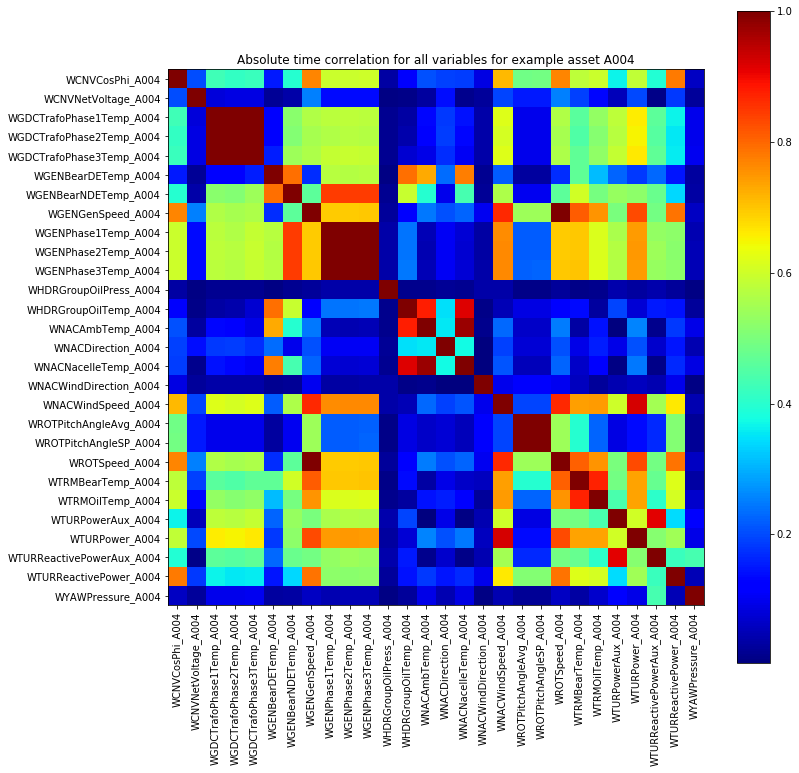

In [8]:
# create a matrix for just one asset
tmp_vars = [x for x in df.columns if assets[0] in x] 
plt.figure(figsize=(12,12))
corr_matrix = abs(df[tmp_vars].corr())
plt.imshow(corr_matrix, cmap='jet')
plt.xticks(range(corr_matrix.shape[0]),df[tmp_vars].columns, rotation='vertical')
plt.yticks(range(corr_matrix.shape[1]),df[tmp_vars].columns)
plt.colorbar()
plt.title("Absolute time correlation for all variables for example asset {}".format(assets[0]))
plt.show()

# 2) Spectral analysis
Time series can also be correlated spectrally, normal correlation would not show this up. For example, $sin(x)$ and $cos(x)$ are intuitively highly correlated but they provide a low correlation coefficient.

## 2.1) Justification

In [9]:
t = np.linspace(1,10,100)
x = np.sin(4*2*np.pi*t/10)
y = np.cos(4*2*np.pi*t/10)
f, axa = plt.subplots(1, 2, figsize=(12,3))
axa[0].plot(t, x)
axa[0].plot(t, y, 'r')
axa[1].scatter(x,y)
plt.show()
print ("Correlation coefficient = {}".format(np.corrcoef(x,y)[0][1]))

Correlation coefficient = -0.023517439312711347


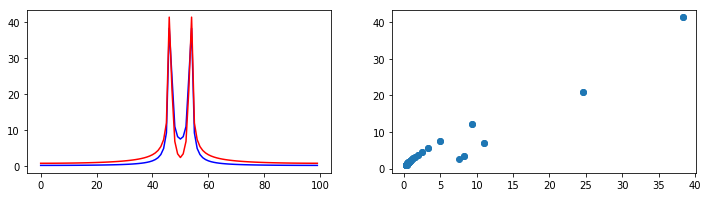

Correlation coefficient = 0.9734851836560191


In [10]:
from scipy.fftpack import fft, fftshift
xf = np.abs(fftshift(fft(x)))
yf = np.abs(fftshift(fft(y)))
f, axa = plt.subplots(1, 2, figsize=(12,3))
axa[0].plot(xf,'b')
axa[0].plot(yf,'r')
axa[1].scatter(xf, yf)
plt.show()
print ("Correlation coefficient = {}".format(np.corrcoef(xf,yf)[0][1]))

## 2.2) Spectral analysis of the signals

### 2.2.1) Spectral components
The shown spectrum has been adapted in such a way that the spectrum is not just a line centered at 0 (DC). Notice that the sampling frequency in this case is  $ f_s = { 1 \over {600} } = 0.00167 Hz $ (which is very low frequency).
- The DC component has been removed since it is the most dominant signal in all signals.
- The bandwith of the plot has been adapted to show 95% of the energy (as per Parsival).
These changes ensure that the spectral features can be observed.

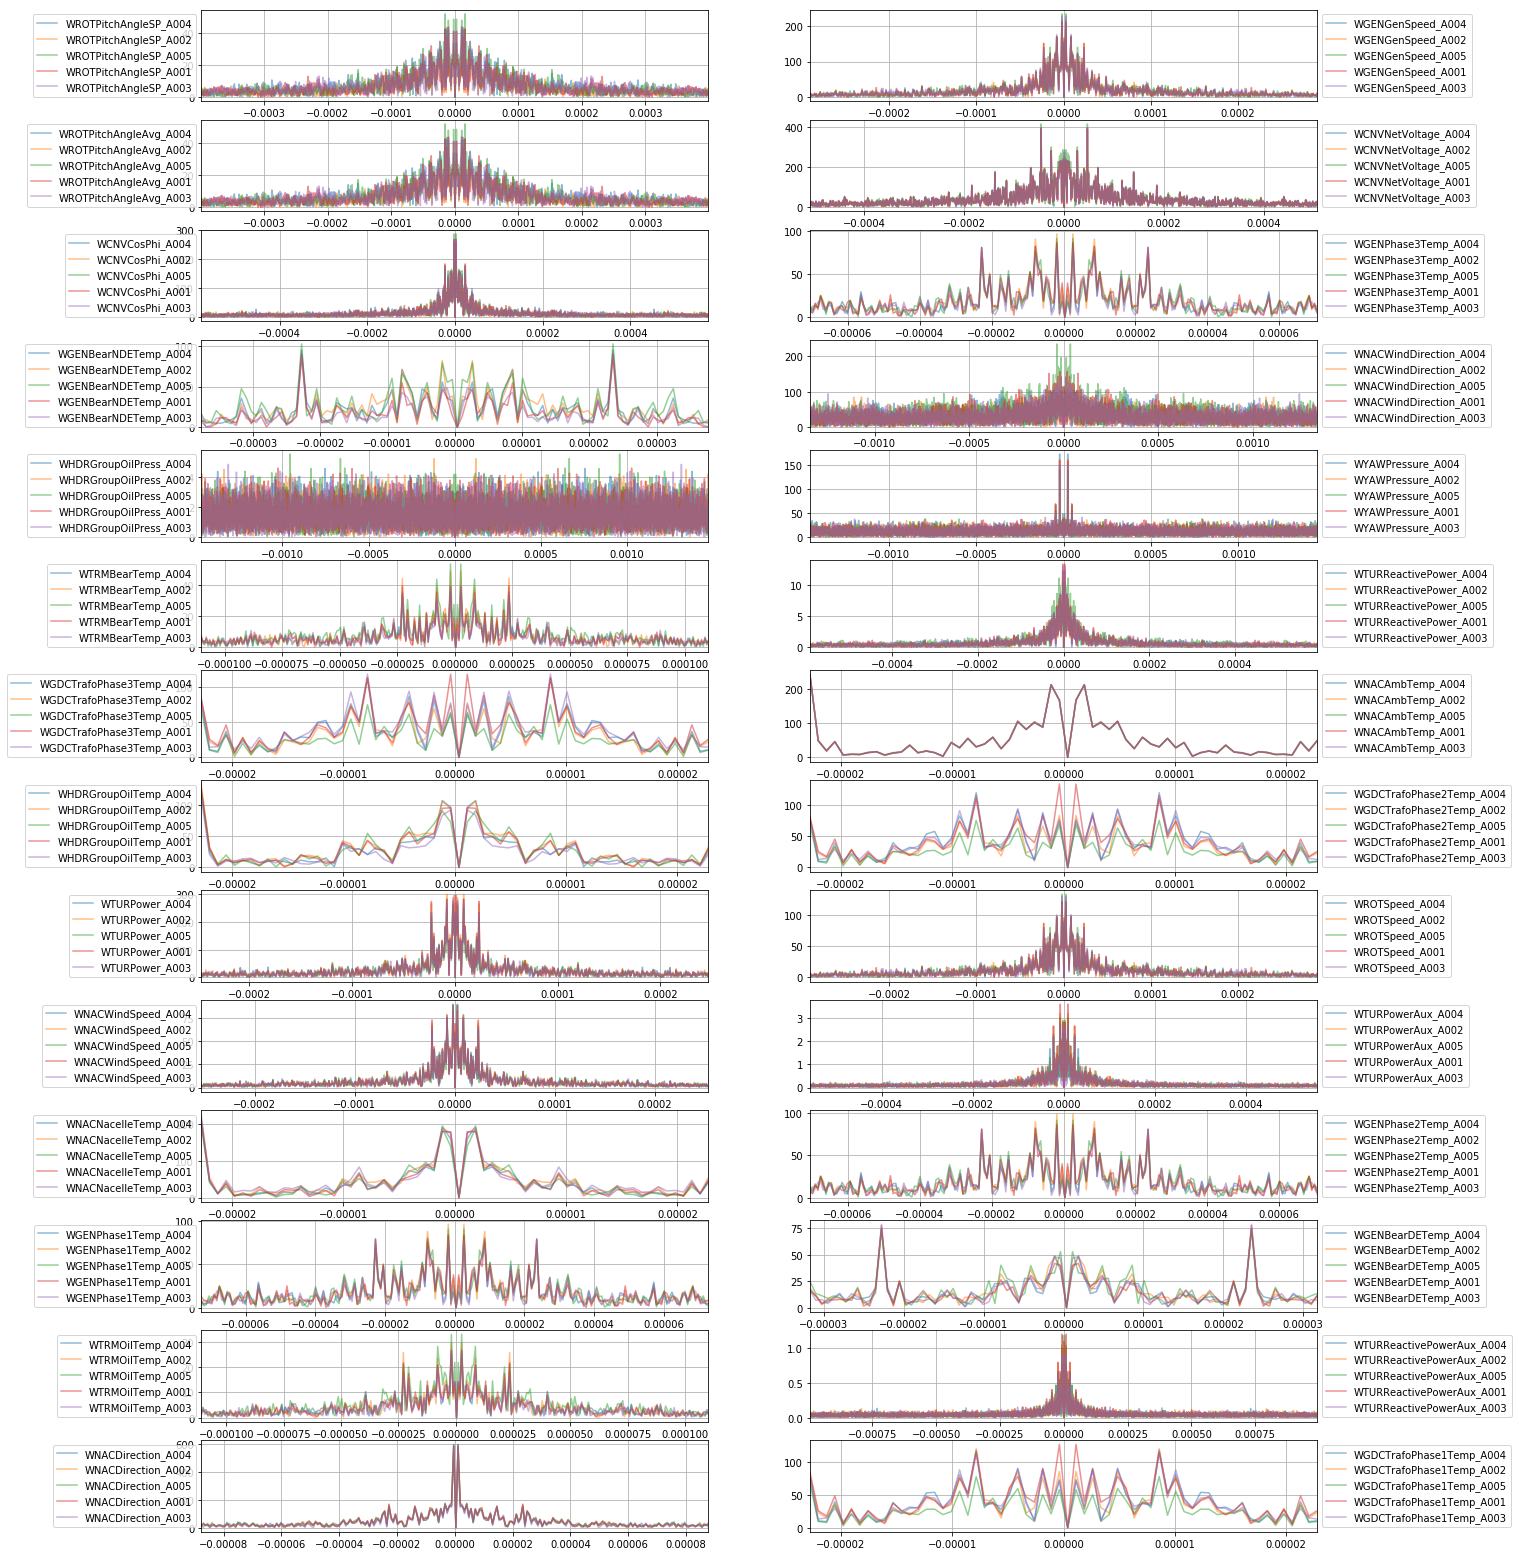

In [11]:
# compute the abs part of the spectrum centered and without DC
def fft_p(x):
    return np.abs(fftshift(fft(x-np.mean(x))))

f = np.linspace(-1/600, 1/600, len(df.index))
dff = df.interpolate().apply(fft_p)
dff.index = f
# retrieve normalized integrated signal for smart rescaling
dfen = (dff**2).cumsum(axis=0)
dfen = dfen/dfen.max()

f, ax = plt.subplots(int(len(variables)/2), 2, figsize=(20,len(variables)), gridspec_kw={'width_ratios':[1,1]}) 
for v in variables:
    tmp_vars = [v + '_' + x for x in assets]
    pos_x = int(variables.index(v)/2)
    pos_y = int(variables.index(v)%2)
    # smart rescaling, zoom on the band where 95% of the energy is contained
    dff.loc[(dfen[tmp_vars].min(axis=1)>5/100) & (dfen[tmp_vars].max(axis=1)<95/100), tmp_vars].plot(ax=ax[pos_x,pos_y], legend=True, alpha=0.5)
    ax[pos_x,pos_y].grid()
    if pos_y == 0:
        ax[pos_x,pos_y].legend(loc='center right', bbox_to_anchor=(0., 0.5))
    else:
        ax[pos_x,pos_y].legend(loc='center left', bbox_to_anchor=(1., 0.5))
plt.show()

### 2.2.2) Spectra correlation

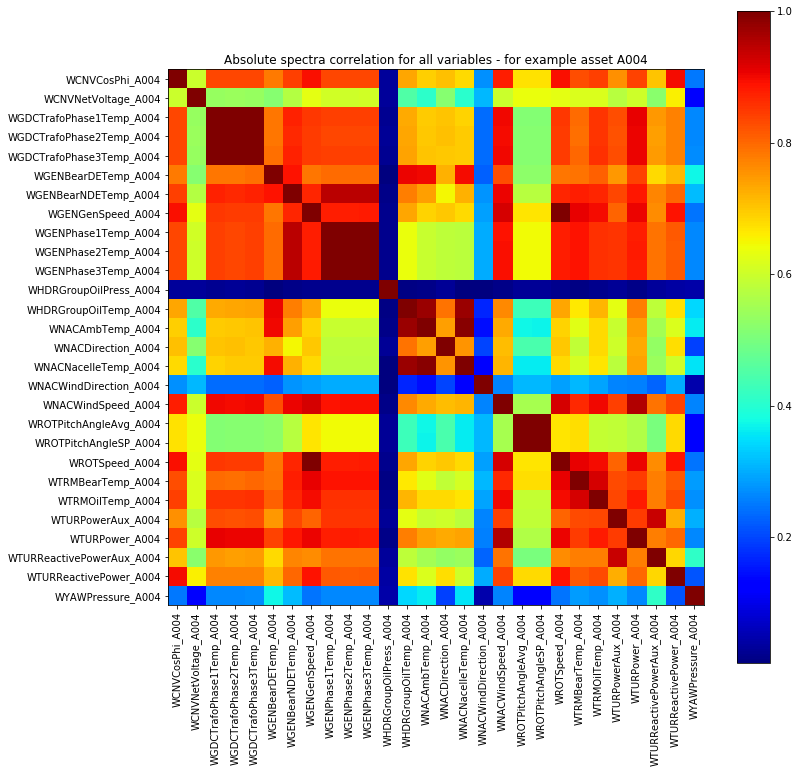

In [12]:
tmp_vars = [x for x in df.columns if assets[0] in x] 
plt.figure(figsize=(12,12))
corr_matrix = abs(dff[tmp_vars].corr())
plt.imshow(corr_matrix, cmap='jet')
plt.xticks(range(corr_matrix.shape[0]),tmp_vars, rotation='vertical')
plt.yticks(range(corr_matrix.shape[1]),tmp_vars)
plt.colorbar()
plt.title("Absolute spectra correlation for all variables - for example asset {}".format(assets[0]))
plt.show()

# 3) Clustering
The goal of this exercise is to evaluate if the data can be grouped in a number of clusters that could describe the state of the system at a given moment. Each data point in a cluster would be then the vector of values (28 dimensions) at a given time (10 min sampling interval). 

Later on a dimensionality reduction technique is called upon to visually understand if those groups to make sense.

Initially, a search for the optimum -yet reasonable- number of clusters is carried out on a single asset, and then this number is extrapolated to the other

Secondly, the best number of clusters is applied to classify the time intervals for each asset. 

Finally, a dimensionality reduction technique is used to visualize the clusters. The chosen technique is T-SNE over classical PCA given its robustness to crowdness.

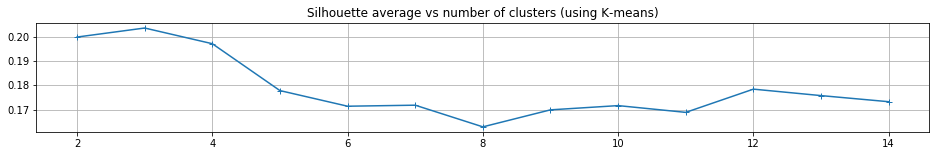

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

MIN_CLUSTERS = 2
MAX_CLUSTERS = 15

dfa = df[[c for c in df.columns if assets[0] in c]]
X_clust = dfa.interpolate(axis=0).values
clust_dict = {k:0 for k in range(MIN_CLUSTERS, MAX_CLUSTERS)}
for k in clust_dict.keys():
    clf = KMeans(n_clusters=k)
    klabels = clf.fit_predict(X_clust)
    clust_dict[k] = silhouette_score(X_clust, klabels)
plt.figure(figsize=(16,2))
plt.plot(list(clust_dict.keys()), list(clust_dict.values()), '+-')
plt.grid()
plt.title('Silhouette average vs number of clusters (using K-means)')
plt.show()

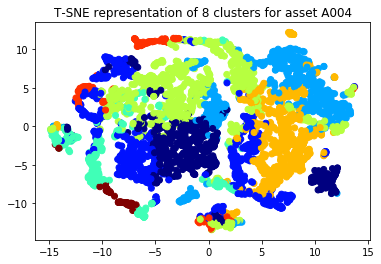

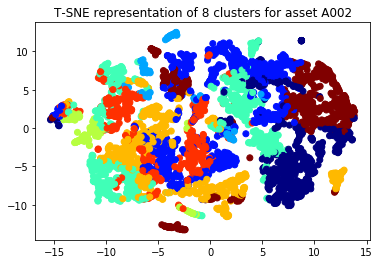

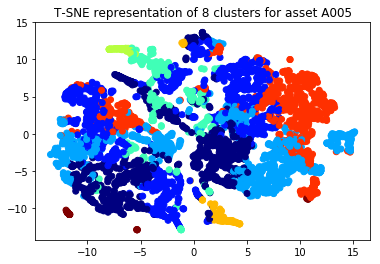

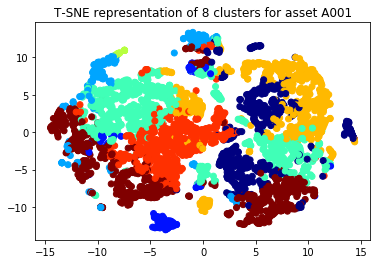

In [15]:
from sklearn.manifold import TSNE

NUM_CLUSTERS = 8

# loop for all assets and create plot of the system
df_labels = pd.DataFrame(index=df.index, columns=assets)
for a in assets:
    dfa = df[[c for c in df.columns if a in c]]
    X_clust = dfa.interpolate(axis=0).values
    clf = clf = KMeans(n_clusters=NUM_CLUSTERS)
    df_labels[a] = clf.fit_predict(X_clust)
    model = TSNE(n_components=2, random_state=0)
    Y_clust = model.fit_transform(X_clust)
    plt.scatter(x=Y_clust.transpose()[0], y=Y_clust.transpose()[1], c=df_labels[a], cmap='jet')
    plt.title("T-SNE representation of {} clusters for asset {}".format(NUM_CLUSTERS, a))
    plt.show()

The analysis does not conclude that the state of each asset can just be describe on two dimensions that can be used to explain the full system behavior.